In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils

/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
noise_filter = True

In [3]:
# Read images
data_files = glob.glob("data/composite_data/2016*.npy")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    noise_imgs = [x.split("/")[-1].replace(".fits", ".npy") for x in noise_imgs]

    data_files = [f for f in data_files if f.split("/")[-1] not in noise_imgs]

data_matrix = np.empty([len(data_files),256,256,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    data_matrix[idx] = data_point

# data_matrix_old = data_matrix.copy()

# data_matrix_norm = dg.MultiChannelAEGenerator.normalize(data_matrix)

# data_matrix_norm[:,:,:,2] = dg.HMImGenerator.apply_filter(data_matrix_norm[:,:,:,2], 4, 2)

# data_matrix_norm[np.isnan(data_matrix_norm_old[:,:,:,2]), 2] = 0 

# input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

# utils.range_tuple(data_matrix_norm)


data_matrix_old = data_matrix.copy()

data_matrix_norm = dg.MultiChannelAEGenerator.normalize(data_matrix)

data_matrix_norm[:,:,:,2] = dg.HMImGenerator.apply_filter(data_matrix_norm[:,:,:,2], 4, 2)

data_matrix_norm[np.isnan(data_matrix_old[:,:,:,2]), 2] = 0 

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

/home/eugeniolr/Documents/master/TFM/data_generator.py:183: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:184: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:192: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


(0.0, 1.0)

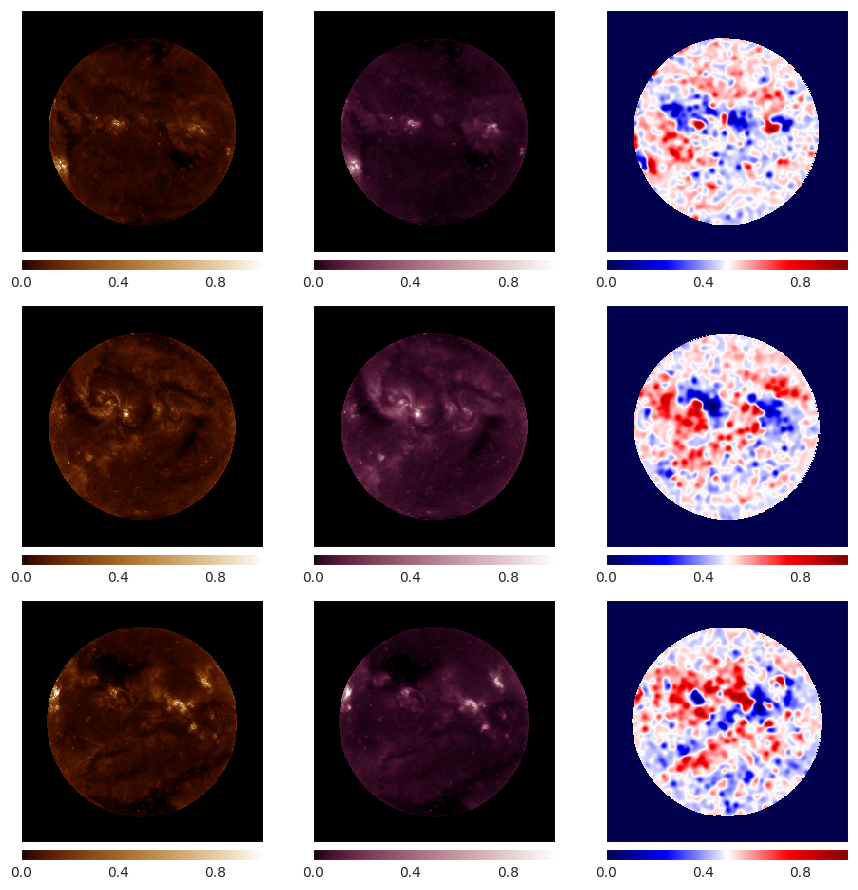

In [4]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)

<AxesSubplot: >

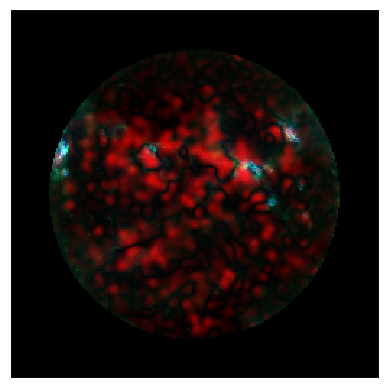

In [5]:
idx = 2

example = data_matrix_norm[idx].copy()
example[np.isnan(data_matrix_old[idx,:,:,2]), 2] = 0.5
example[:,:,2] = np.abs(2*example[:,:,2] - 1)
isns.imgplot(np.roll(example, axis=2, shift=1))

In [6]:
latent_size = 128
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
n_epochs = 125
batch_size = 16

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/125
105/105 [==============================] - 19s 112ms/step - loss: 0.0259 - mae: 0.0961 - val_loss: 0.0258 - val_mae: 0.0903
Epoch 2/125
105/105 [==============================] - 9s 86ms/step - loss: 0.0064 - mae: 0.0433 - val_loss: 0.0069 - val_mae: 0.0426
Epoch 3/125
105/105 [==============================] - 9s 86ms/step - loss: 0.0048 - mae: 0.0336 - val_loss: 0.0235 - val_mae: 0.0998
Epoch 4/125
105/105 [==============================] - 9s 86ms/step - loss: 0.0043 - mae: 0.0303 - val_loss: 0.0398 - val_mae: 0.0958
Epoch 5/125
105/105 [==============================] - 9s 87ms/step - loss: 0.0039 - mae: 0.0280 - val_loss: 0.0436 - val_mae: 0.0980
Epoch 6/125
105/105 [==============================] - 9s 87ms/step - loss: 0.0038 - mae: 0.0269 - val_loss: 0.0044 - val_mae: 0.0280
Epoch 7/125
105/105 [==============================] - 9s 87ms/step - loss: 0.0037 - mae: 0.0260 - val_loss: 0.0053 - val_mae: 0.0288
Epoch 8/125
105/105 [==============================] - 9s 87

2023-04-23 23:39:12.713800: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 504.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-23 23:39:12.713836: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 504.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-23 23:39:12.713845: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 504.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-23 23:39:12.713853: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

20/20 [==============================] - 2s 43ms/step - loss: 0.0021 - mae: 0.0190


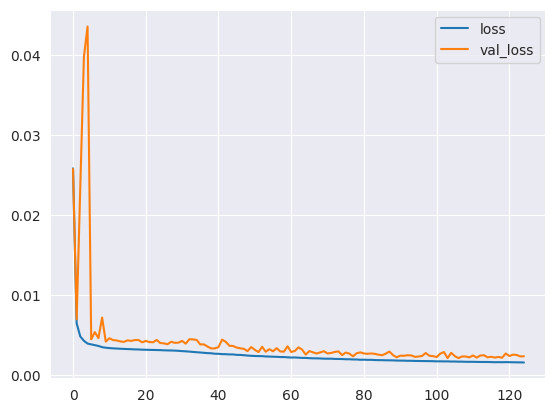

In [8]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(1, 256, 256, 3)


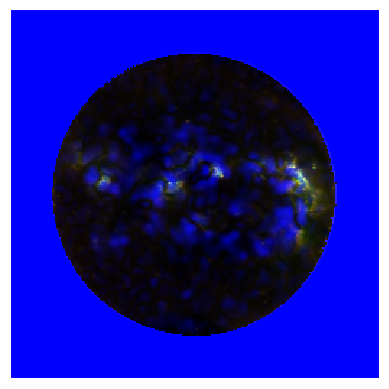

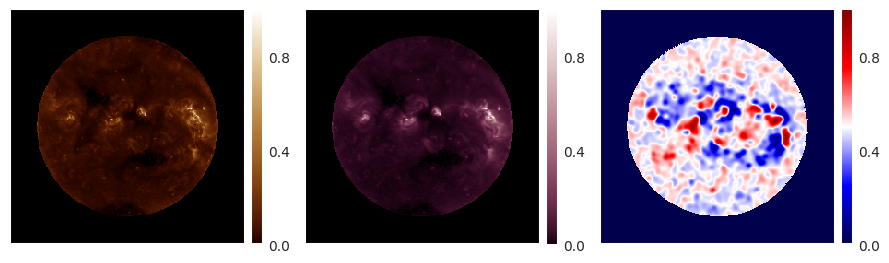

In [21]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

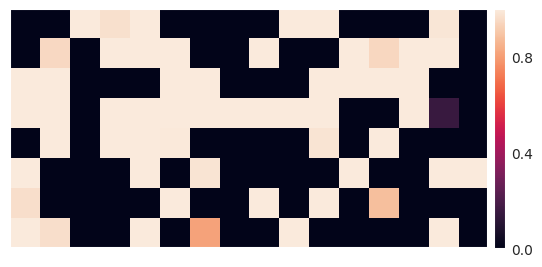

In [22]:
code = encoder(test_img)

isns.imgplot(utils.square_dims_vector(np.asarray(code)), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


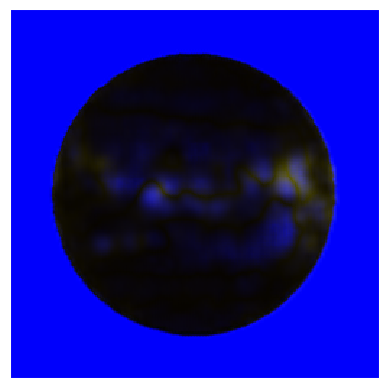

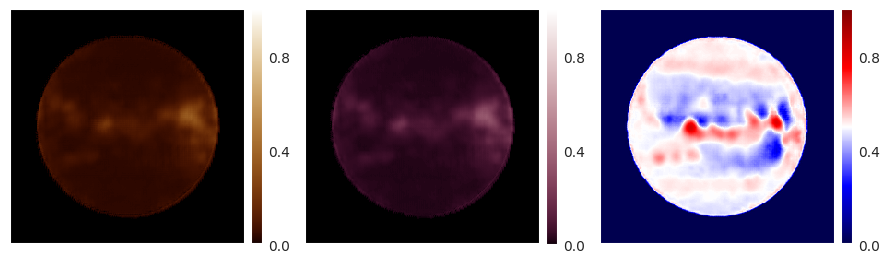

In [23]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

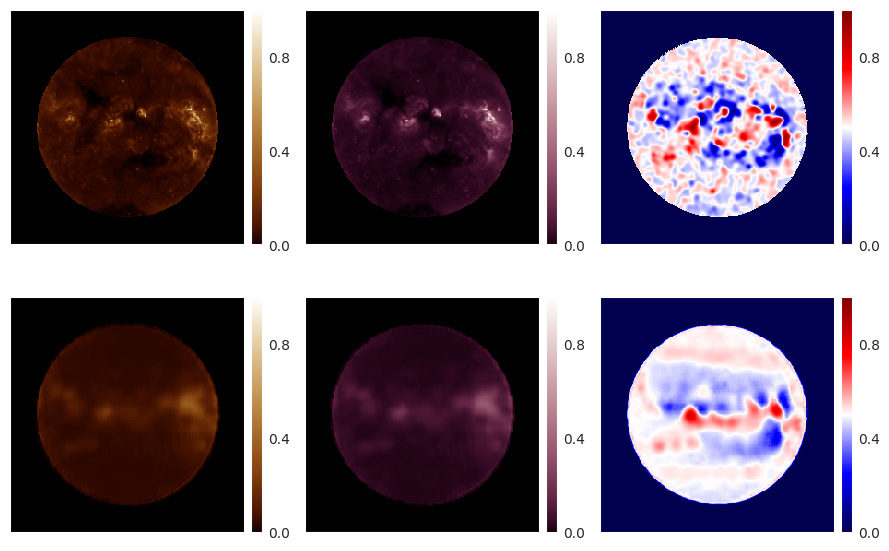

In [24]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1)